In [ ]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')


# Read and prepare data for analysis

In [ ]:
sample_relationships = pd.read_table(sample_relationships_df_loc)
sample_relationships.encapsulation_sibling_sample = sample_relationships.encapsulation_sibling_sample.fillna("")
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x.sample_uid_vdj, x.encapsulation_sibling_sample])), axis=1)
sample_relationships= sample_relationships.set_index('sample_uid_vdj')



df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[df.vdj_sequence.notna()]
df['emulsion'] = df.sample_uid_vdj.map(sample_relationships['emulsion'])

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)]
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]



## Construct VDJ droplet count dataframe for all vdjs and those known to belong to clean B cells

In [ ]:
# def count_and_pivot(data_frame, index_col, column_col, 
#                     fill_value=None,
#                    downsample_to_smallest=False, 
#                    min_vdjs_per_sample=None, 
#                    n_replicates=1):

#     if min_vdjs_per_sample is None:
#         new_df =  data_frame.copy()
#     else:
#         # drop samples with fewer than min_vdjs_per_sample
#         sufficiently_large_sample_uids = data_frame.groupby(column_col)[index_col].nunique()
#         print('dropping the following low-VDJ samples:')
#         print(sufficiently_large_sample_uids[sufficiently_large_sample_uids < min_vdjs_per_sample])
#         sufficiently_large_sample_uids = sufficiently_large_sample_uids[sufficiently_large_sample_uids >= min_vdjs_per_sample].index
#         new_df = data_frame[data_frame[column_col].isin(sufficiently_large_sample_uids)]

#     RETAINED_SAMPLES = new_df[column_col].unique()
#     #drop down to unique vdjs
#     new_df = new_df.groupby([index_col, column_col]).size().reset_index()
#     count_dfs = []
#     for replicate_it in range(n_replicates):
#         if downsample_to_smallest:
#             n = int(new_df.groupby(column_col).size().min())
#             # print(n)
#             count_df = new_df.groupby(column_col).sample(n=n, replace=False)
#             # print(count_df[column_col].value_counts())
#         if fill_value is None:
#             count_df = count_df.pivot(index=index_col, columns = column_col, values=0)
#         else:
#             count_df = count_df.pivot(index=index_col, columns = column_col, values=0).fillna(fill_value).astype('int64')
#         count_df['replicate'] = replicate_it  + 1
#         count_df = count_df.reset_index().set_index([index_col, 'replicate'])
#         count_dfs.append(count_df)
    
#     count_df = pd.concat(count_dfs, axis=0)
#     return count_df, RETAINED_SAMPLES

# cell_counts_all, RETAINED_SAMPLES = count_and_pivot(df, 'vdj_sequence', 'emulsion', 
#                                   downsample_to_smallest=True,
#                                   min_vdjs_per_sample=3000,
#                                   n_replicates=100)
# import warnings
# warnings.filterwarnings(action='ignore')
# new_cols_all = {}
# for col in cell_counts_all.columns:
#     if col != 'replicate':
#         new_cols_all.update({f'{col}_binned':2**round(np.log10(cell_counts_all[col])/np.log10(2))})
#         new_cols_all.update({f'{col}_binarized': cell_counts_all[col].notna()})

# new_cols_all = pd.DataFrame(new_cols_all)
# cell_counts_all = cell_counts_all.join(new_cols_all)

# sample_relationships = sample_relationships[sample_relationships.emulsion.isin(RETAINED_SAMPLES)]

# cell_counts_all.to_csv('cell_counts_all_min_vdjs_3000_n_replicates_100.tsv.gz', sep='\t')

## Set up data structures for sharing analysis

In [ ]:
cell_counts_all = pd.read_table('cell_counts_all_min_vdjs_3000_n_replicates_100.tsv.gz')

In [ ]:
n_vdjs = df.groupby(['emulsion'])['vdj_sequence'].nunique().sort_values()
expected_emulsions = n_vdjs[n_vdjs >= 3000].index
RETAINED_SAMPLES = [x for x in cell_counts_all.columns if x.startswith(("TBd",";")) and not x.endswith(("binned", "binarized"))]
print(all(x in RETAINED_SAMPLES for x in expected_emulsions))
print(all(x in expected_emulsions for x in RETAINED_SAMPLES))

True
True


In [ ]:
sample_relationships = sample_relationships[sample_relationships.emulsion.isin(RETAINED_SAMPLES)]

In [ ]:
sample_relationships['subanatomical'] = sample_relationships.donor_subanatomical.map(lambda x: x.split("_")[-1])

subanatomical_list = sample_relationships.subanatomical.unique()
subanatomical_indices = {'PB':0, 'BM':1, 'SP':2, 'SDLN':3, 'MELN':4}

tissue_dict = sample_relationships[['emulsion','subanatomical']].drop_duplicates(ignore_index=True).set_index('emulsion')['subanatomical'].to_dict()

donor_tissue_list = sample_relationships.groupby('donor_subanatomical')['emulsion'].unique()
donor_tissue_availability = sample_relationships.groupby('donor')['donor_subanatomical'].unique()

sibling_pairs = sample_relationships.encapsulation_sibling_sample[sample_relationships.encapsulation_sibling_sample.notna()].to_dict()
sample_replicates = sample_relationships.reset_index().groupby(['cell_suspension'])['emulsion'].agg(list).to_dict()
tissue_replicates = sample_relationships.reset_index().groupby(['donor_subanatomical'])['emulsion'].agg(list).to_dict()
sample_replicate_dict = {}
for cell_suspension, samples in sample_replicates.items():
    for x in samples:
        sample_replicate_dict.update({x:[y for y in samples if not (y == x)]})
        
tissue_replicate_dict = {}
for tissue, samples in tissue_replicates.items():
    for x in samples:
        exclude=[x] + sample_replicate_dict.get(x)
        if len(exclude) < len(samples):
            tissue_replicate_dict.update({x:[y for y in samples if not (y in exclude)]})


In [ ]:
norm_dict = {x:sample_replicate_dict.get(x,[]) + tissue_replicate_dict.get(x,[]) 
             for x in (list(sample_replicate_dict.keys()) + list(tissue_replicate_dict.keys()))}
test_dict = {(t,dt):{} for t, dt in permutations(subanatomical_list,2)}
for t, dt in test_dict.keys():
        relevant_donors = [d for d in donors if (f'{d}_{dt}' in donor_tissue_availability[d]) 
                                            and (f'{d}_{t}' in donor_tissue_availability[d])]
        
        for d in relevant_donors:
            print(t, donor_tissue_list[f'{d}_{t}'], donor_tissue_list[f'{d}_{dt}'])
            test_dict[(t,dt)].update({d:
                                      {x:[y 
                                          for y in donor_tissue_list[f'{d}_{dt}']
                                         ] 
                                      for x in donor_tissue_list[f'{d}_{t}']
                                      } 
                                     })


BM ['TBd1_frozen_BM_HTa;TBd1_frozen_BM_HTb'
 'TBd1_frozen_BMover_HTa;TBd1_frozen_BMover_HTb'] ['TBd1_frozen_MELN_HTa;TBd1_frozen_MELN_HTb'
 'TBd1_frozen_MELNover_HTa;TBd1_frozen_MELNover_HTb']
BM ['TBd1_frozen_BM_HTa;TBd1_frozen_BM_HTb'
 'TBd1_frozen_BMover_HTa;TBd1_frozen_BMover_HTb'] ['TBd1_frozen_PB_HTa;TBd1_frozen_PB_HTb'
 'TBd1_frozen_PBover_HTa;TBd1_frozen_PBover_HTb']
BM ['TBd2_frozen_BM_HTa;TBd2_frozen_BM_HTb'
 'TBd2_frozen_BMover_HTa;TBd2_frozen_BMover_HTb'] [';TBd2_frozen_PB_a' ';TBd2_frozen_PB_b']
BM [';TBd3_fresh_BM_b' 'TBd3_frozen_BM_HTa;TBd3_frozen_BM_HTb'
 'TBd3_frozen_BMover_HTa;TBd3_frozen_BMover_HTb'] [';TBd3_fresh_PB_a' ';TBd3_fresh_PB_b'
 'TBd3_frozen_PB_HTa;TBd3_frozen_PB_HTb'
 'TBd3_frozen_PBover_HTa;TBd3_frozen_PBover_HTb']
BM ['TBd4_frozen_BM_HTa;TBd4_frozen_BM_HTb'
 'TBd4_frozen_BMover_HTa;TBd4_frozen_BMover_HTb'] ['TBd4_frozen_PB_HTa;TBd4_frozen_PB_HTb'
 'TBd4_frozen_PBover_HTa;TBd4_frozen_PBover_HTb']
BM [';TBd5_fresh_BM_a' ';TBd5_fresh_BM_b'
 'TBd5_frozen_BM

## Define function to calculate relative sharing amounts

In [ ]:
def calculate_discovery_prob_unscaled(data_frame, test_dict, 
                                     filter_on = [],
                                     filter_col_suffix='labels'):
    all_freqs = []
    for k in test_dict.keys():
        test_cols = [f'{x}_binarized' for x in test_dict[k]]
        
        if type(k) is tuple:
            n_keys = len(k)
            present = data_frame[[f'{s}_binarized' for s in k]].sum(axis=1) == n_keys
        else:
            n_keys = 1
            present = data_frame[f'{k}_binarized']
        
        if len(filter_on) > 0:
            if type(k) is tuple:
                filter_cols = [f'{s}_{filter_col_suffix}' for s in k ]
            else:
                filter_cols = [f'{k}_{filter_col_suffix}']
            
            _filter = (data_frame[filter_cols].isin(filter_on)).all(axis=1)
            present = present & _filter
        
        freqs = data_frame.groupby([present,'replicate'])[test_cols].mean()

        freqs[f'{k}_test_mean'] = freqs[test_cols].mean(axis=1)
        all_freqs.append(freqs[f'{k}_test_mean'])
    if len(all_freqs)>0:
        all_freqs = pd.concat(all_freqs, axis=1)

        all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].mean(axis=1)
        all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('test_mean')]].std(axis=1)
        ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
        all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))
        try:
            all_freqs = all_freqs.reset_index()
            all_freqs = all_freqs.groupby(['level_0']).mean()
            all_freqs = all_freqs.T[True].T
        except KeyError:
            all_freqs =  pd.Series(index=['mean_ratio', 'std_ratio', 'std_err'], dtype=pd.Float64Dtype)
    else:
        all_freqs = pd.DataFrame()
    return all_freqs

def calculate_discovery_prob_scaled(data_frame, 
                                    norm_dict, 
                                    test_dict,
                                    filter_on = [],
                                    filter_col_suffix='labels',
                                    debug=False):
    all_freqs = []
    EPS=1
    for k in test_dict.keys():
        norm_cols = [f'{x}_binarized' for x in norm_dict[k]]
        test_cols = [f'{x}_binarized' for x in test_dict[k]]
        all_cols = norm_cols + test_cols

        if type(k) is tuple:
            n_keys = len(k)
            present = data_frame[[f'{s}_binarized' for s in k]].sum(axis=1) == n_keys
            key_string = "_".join(list(k))
        else:
            n_keys = 1
            present = data_frame[f'{k}_binarized']
            key_string = k
            
        if len(filter_on) > 0:
            if type(k) is tuple:
                filter_cols = [f'{s}_{filter_col_suffix}' for s in k]
            else:
                filter_cols = [f'{k}_{filter_col_suffix}']
            
            _filter = (data_frame[filter_cols].isin(filter_on)).all(axis=1)
            present = present & _filter
        
        freqs = data_frame.groupby([present, 'replicate'])[all_cols].sum()
        freqs[f'{key_string}_norm_mean'] = freqs[norm_cols].mean(axis=1)
        freqs[f'{key_string}_test_mean'] = freqs[test_cols].mean(axis=1)
        freqs[f'{key_string}_ratio'] = (freqs[f'{key_string}_test_mean']+EPS)\
                                        /(freqs[f'{key_string}_norm_mean']+EPS)
        all_freqs.append(freqs[[f'{key_string}_norm_mean', 
                                f'{key_string}_test_mean', 
                                f'{key_string}_ratio']])

    if len(all_freqs) > 0:
        all_freqs = pd.concat(all_freqs, axis=1)
    
        all_freqs['mean_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].mean(axis=1)
        all_freqs['std_ratio'] = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].std(axis=1)
        ns = all_freqs[[x for x in all_freqs.columns if x.endswith('ratio')]].notna().sum(axis=1)
        all_freqs['std_err'] = all_freqs['std_ratio']/np.sqrt(np.maximum(ns-1,1))

        try:
            all_freqs = all_freqs.reset_index()
            all_freqs = all_freqs.groupby(['level_0']).mean()
            all_freqs = all_freqs.T[True].T
        except KeyError:
            all_freqs = pd.Series(index=['mean_ratio', 'std_ratio', 'std_err'], dtype=pd.Float64Dtype)
    else:
        all_freqs = pd.Series()
    return all_freqs


## Now calculate sharing statistics

In [ ]:
rows = []
for t1, t2 in test_dict.keys():
    for d, relevant_test_dict in test_dict[(t1,t2)].items():
        probs = calculate_discovery_prob_scaled(cell_counts_all, 
                                                           norm_dict, 
                                                           relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1}',
                         'discovery_tissue':t2,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':1})
        rows.append(row)

prob_df = pd.DataFrame(rows)
prob_df


,donor,ascertained_in,discovery_tissue,mean,std_err,n_ascertainment
0,TBd1,BM,MELN,0.096568,0.007988,1
1,TBd1,BM,PB,0.550368,0.038563,1
2,TBd2,BM,PB,0.200262,0.031095,1
3,TBd3,BM,PB,0.367193,0.044032,1
4,TBd4,BM,PB,0.819415,0.033383,1
...,...,...,...,...,...,...
71,TBd6,SDLN2,PB,0.541475,0.101800,1
72,TBd6,SDLN2,SDLN1,0.764674,0.139601,1
73,TBd6,SDLN2,SP,0.609903,0.085258,1
74,TBd6,SDLN2,SDLN3,0.996446,0.163667,1


In [ ]:

rows = []
for t1, t2 in test_dict.keys():
    for d, relevant_test_dict in test_dict[(t1,t2)].items():
        probs = calculate_discovery_prob_unscaled(cell_counts_all, 
                                                           relevant_test_dict)
        row = pd.Series({'donor':d, 
                         'ascertained_in':f'{t1}',
                         'discovery_tissue':t2,
                         'mean':probs['mean_ratio'],
                         'std_err':probs['std_err'],
                         'n_ascertainment':1})
        rows.append(row)

unscaled_prob_df = pd.DataFrame(rows)

# unscaled_prob_df

## Plot

In [ ]:
# drop nan's
prob_df = prob_df[prob_df['mean'].notna()]
unscaled_prob_df = unscaled_prob_df[unscaled_prob_df['mean'].notna()]

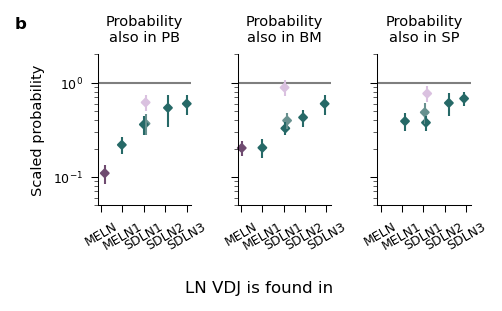

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(3.25,2), sharey=True, sharex=True)
ax[0].text(0,0.9, 'b', weight='bold', fontsize=8, transform=fig.transFigure)

xtick_positions = {'MELN':0, 'MELN1':1, 'SDLN1':2, 'SDLN2':3, 'SDLN3':4}
xticklabels = ['MELN', 'MELN1', 'SDLN1', 'SDLN2','SDLN3']
xticks = np.arange(5)

prob_df = prob_df.sort_values('ascertained_in')
for i, dt in enumerate(['PB','BM','SP']):
    axis = ax[i]
    relevant_df = prob_df[(prob_df.discovery_tissue==dt) & (prob_df.ascertained_in.str.contains("LN"))]
                       
    jitter = np.random.uniform(0, .3, size= relevant_df.shape[0]) -.1
    xvals = relevant_df['ascertained_in'].map(xtick_positions) + jitter
    yvals = relevant_df['mean']
    colors = relevant_df['donor'].map(donor_colors)
    errors = relevant_df['std_err']
    
    ax[i].scatter(xvals, yvals, color=colors, clip_on=False, marker='D', s=7)

    try: 
        ax[i].errorbar(xvals,
                   yvals,
                   2*errors, 
                   ecolor=colors,
                   fmt=' ')
    except ValueError:
        print(tissue, errors)
    ax[i].set_yscale('log')
    ax[i].set_ylim([5*10**-2,2])
    ax[i].set_title(f'Probability\nalso in {dt}')

    ax[i].axhline(y=1, color='k', alpha=0.5, zorder=-1)
    if i in [0]:
        ax[i].set_ylabel('Scaled probability')
    else:
        ax[i].set_ylabel('')
    ax[i].set_xticks(xticks,xticklabels)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(30)

sns.despine(fig)
fig.supxlabel('LN VDJ is found in', fontsize=8)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/VDJsharing_LNascertainment_EPS_1_downsample_3000.pdf', bbox_inches='tight')

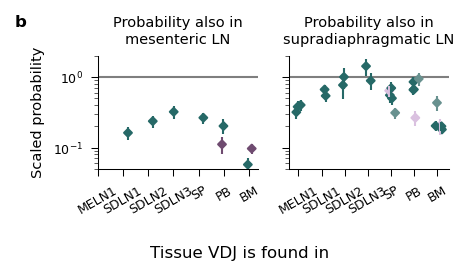

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(3,1.75), sharey=True, sharex=False)
ax[0].text(0,0.9, 'b', weight='bold', fontsize=8, transform=fig.transFigure)

xtick_positions = {'MELN1':1, 'SDLN1':2, 'SDLN2':3, 'SDLN3':4, 'SP':5, 'PB':6, 'BM':7}
xticklabels = ['MELN1', 'SDLN1', 'SDLN2','SDLN3', 'SP', 'PB', 'BM']
xticks = [xtick_positions[tick] for tick in xtick_positions]

title_dict = {'MELN':'mesenteric LN',
              'SDLN':'supradiaphragmatic LN'}

prob_df = prob_df.sort_values('ascertained_in')
for i, dt in enumerate(['MELN','SDLN']):
    axis = ax[i]
    relevant_df = prob_df[(prob_df.discovery_tissue.str.contains(dt))]

    jitter = np.random.uniform(0, .3, size= relevant_df.shape[0]) -.1
    xvals = relevant_df['ascertained_in'].map(xtick_positions) + jitter
    yvals = relevant_df['mean']
    colors = relevant_df['donor'].map(donor_colors)
    errors = relevant_df['std_err']
    
    ax[i].scatter(xvals, yvals, color=colors, clip_on=False, marker='D', s=7)

    try: 
        ax[i].errorbar(xvals,
                   yvals,
                   2*errors, 
                   ecolor=colors,
                   fmt=' ')
    except ValueError:
        print(tissue, errors)
    ax[i].set_yscale('log')
    ax[i].set_ylim([5*10**-2,2])
    ax[i].set_title(f'Probability also in\n{title_dict[dt]}')

    ax[i].axhline(y=1, color='k', alpha=0.5, zorder=-1)

    ax[i].set_xticks(xticks,xticklabels)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(30)
    if i in [0]:
        ax[i].set_ylabel('Scaled probability')
    else:
        ax[i].set_ylabel('')

sns.despine(fig)
fig.supxlabel('Tissue VDJ is found in', fontsize=8)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/VDJsharing_LNsecond_EPS_1_downsample_3000.pdf', bbox_inches='tight')